## Grid Search

In [1]:
from sklearn.datasets import fetch_california_housing
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
import lightgbm as lgb

In [2]:
dataset = fetch_california_housing()
X = pd.DataFrame(dataset['data'], columns=dataset['feature_names'])
y = dataset['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

In [3]:
# モデル
lgbmr = lgb.LGBMRegressor(random_state=0)

# gridsearchしたいパラメータ
param_grid = {'num_leaves': [10, 20, 30, 40, 50, 60],
              'max_depth': [5, 10, 15], 
              'reg_alpha': [0, 0.01, 0.03]}

cv = KFold(n_splits=3, random_state=0, shuffle=True)
gs = GridSearchCV(lgbmr, param_grid=param_grid, cv=cv)


もし、max_depth：5でnum_leaves：10-30で　max_depth:10-60でmax_depth:10-60と条件で分けたいなら、  
二つのparam_gridを作成して回すことになる。

param_grid_1 = {'num_leaves': [10, 20, 30],  
              'max_depth': [5],   
              'reg_alpha': [0, 0.01, 0.03]}  
              
param_grid_2 = {'num_leaves': [10, 20, 30, 40, 50, 60],  
              'max_depth': [10, 15],   
              'reg_alpha': [0, 0.01, 0.03]}  

In [4]:
# fitにおけるearly_stoppingの設定

callbacks = [lgb.early_stopping(stopping_rounds=10)]
eval_set = [(X_val, y_val)]
fit_params = {'callbacks': callbacks, 'eval_set': eval_set} 

gs.fit(X_train, y_train, **fit_params)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1837
[LightGBM] [Info] Number of data points in the train set: 11008, number of used features: 8
[LightGBM] [Info] Start training from score 2.064558
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.264841
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000421 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1837
[LightGBM] [Info] Number of data points in the train set: 11008, number of used features: 8
[LightGBM] [Info] Start training from score 2.075166
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.256456
[LightGBM] [Info] Auto-choosing col-wise m

GridSearchCV(cv=KFold(n_splits=3, random_state=0, shuffle=True),
             estimator=LGBMRegressor(random_state=0),
             param_grid={'max_depth': [5, 10, 15],
                         'num_leaves': [10, 20, 30, 40, 50, 60],
                         'reg_alpha': [0, 0.01, 0.03]})

In [5]:
cv_result_df = pd.DataFrame(gs.cv_results_)
cv_result_df.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_num_leaves,param_reg_alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.145060,0.044102,0.011458,0.001134,5,10,0,"{'max_depth': 5, 'num_leaves': 10, 'reg_alpha'...",0.797096,0.807785,0.805461,0.803448,0.004590,54
1,0.087481,0.003381,0.011705,0.000407,5,10,0.01,"{'max_depth': 5, 'num_leaves': 10, 'reg_alpha'...",0.798894,0.806981,0.806050,0.803975,0.003613,53
2,0.095865,0.001586,0.012311,0.001794,5,10,0.03,"{'max_depth': 5, 'num_leaves': 10, 'reg_alpha'...",0.799277,0.806364,0.806658,0.804100,0.003413,52


In [6]:
for index, row in cv_result_df[cv_result_df['rank_test_score']<=5].iterrows():
    print(f'{row["rank_test_score"]}: {row["params"]}')
    print(f'{row["mean_test_score"]}')    

4: {'max_depth': 10, 'num_leaves': 50, 'reg_alpha': 0.01}
0.8329725903236045
3: {'max_depth': 15, 'num_leaves': 50, 'reg_alpha': 0}
0.8331058990226472
2: {'max_depth': 15, 'num_leaves': 50, 'reg_alpha': 0.03}
0.8332059773155042
5: {'max_depth': 15, 'num_leaves': 60, 'reg_alpha': 0}
0.8327661059213919
1: {'max_depth': 15, 'num_leaves': 60, 'reg_alpha': 0.01}
0.8338051795879502


In [35]:
lgbmr = lgb.LGBMRegressor(**gs.best_params_, random_state=0, learning_rate=0.01, n_estimators=1000)
lgbmr.fit(X_train, y_train, **fit_params)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000760 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1838
[LightGBM] [Info] Number of data points in the train set: 16512, number of used features: 8
[LightGBM] [Info] Start training from score 2.072499
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.195693


LGBMRegressor(learning_rate=0.01, max_depth=15, n_estimators=1000,
              num_leaves=60, random_state=0, reg_alpha=0.01)

In [36]:
lgbmr.score(X_val, y_val)

0.8499232425233268

## PIpeline + Grid Search

PipelineとGrid Searchを組み合わせることで、前処理を含めてGrid Searchが可能になりコードも綺麗になる

In [7]:
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import warnings
warnings.simplefilter('ignore')

In [8]:
df = pd.read_csv('document/penguins_size.csv')


# データクリーニング
df.loc[df['sex']=='.', 'sex'] = np.nan
df.dropna(thresh=3, inplace=True)


# データ準備
X = df.drop('species', axis=1)
y = df['species']

In [9]:
# Pipeline + Gridsearch
#----必要な前処理--------
# カテゴリ変数のダミー変数化
# 欠損値代入


# 欠損値代入(最頻値)
imputer = SimpleImputer(strategy='most_frequent')
cat_cols = make_column_selector(dtype_exclude=np.number)

# defaultだとremainderはdropで変換対象以外のカラムは落ちる。'passthrough'への変更忘れずに！！
ct = ColumnTransformer([('cat_imputer', imputer, cat_cols)], remainder='passthrough')
ct.set_output(transform='pandas')

# ohe-hot encoding
class GetDummies(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self.columns = None
    
    def fit(self, X, y=None):
        self.columns = pd.get_dummies(X).columns
        return self
    
    def transform(self, X):
        X_new = pd.get_dummies(X, )
        return X_new.reindex(columns=self.columns, fill_value=0)
    
    
# model
lgbmc =  lgb.LGBMClassifier(random_state=0, verbose=-1)


# pipeline
pipeline = Pipeline([('impute', ct), ('dummy', GetDummies()), ('model', lgbmc)])


# cv
cv = KFold(n_splits=3, random_state=0, shuffle=True)


# grid search
# piplenのGrid Searchなのでkeyの接頭辞にモデル名を入れる必要がある 
param_grid = {'model__num_leaves': [10, 20, 30, 40, 50, 60],
              'model__max_depth': [5, 10, 15], 
              'model__reg_alpha': [0, 0.01, 0.03]}
gs = GridSearchCV(pipeline, param_grid=param_grid, cv=cv)


In [123]:
gs.fit(X, y)

GridSearchCV(cv=KFold(n_splits=3, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('impute',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat_imputer',
                                                                         SimpleImputer(strategy='most_frequent'),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fe2e83defd0>)])),
                                       ('dummy', GetDummies()),
                                       ('model',
                                        LGBMClassifier(random_state=0,
                                                       verbose=-1))]),
             param_grid={'model__max_depth': [5, 10, 15],
                         'model__num_leaves': [10, 20, 30, 40, 50, 60],
                         'model__reg_alpha': [0, 0.01, 0.03]})

In [131]:
pd.DataFrame(gs.cv_results_).sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__max_depth,param_model__num_leaves,param_model__reg_alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.109075,0.072923,0.013489,0.001035,5,10,0,"{'model__max_depth': 5, 'model__num_leaves': 1...",0.991228,0.982456,0.991228,0.988304,0.004135,1
33,0.060038,0.001558,0.012770,0.000355,10,60,0,"{'model__max_depth': 10, 'model__num_leaves': ...",0.991228,0.982456,0.991228,0.988304,0.004135,1
27,0.058181,0.002305,0.012484,0.000334,10,40,0,"{'model__max_depth': 10, 'model__num_leaves': ...",0.991228,0.982456,0.991228,0.988304,0.004135,1
24,0.058732,0.003683,0.013267,0.000367,10,30,0,"{'model__max_depth': 10, 'model__num_leaves': ...",0.991228,0.982456,0.991228,0.988304,0.004135,1
36,0.053567,0.000852,0.012693,0.000822,15,10,0,"{'model__max_depth': 15, 'model__num_leaves': ...",0.991228,0.982456,0.991228,0.988304,0.004135,1
21,0.069846,0.006439,0.013699,0.000775,10,20,0,"{'model__max_depth': 10, 'model__num_leaves': ...",0.991228,0.982456,0.991228,0.988304,0.004135,1
39,0.054289,0.001411,0.011731,0.000896,15,20,0,"{'model__max_depth': 15, 'model__num_leaves': ...",0.991228,0.982456,0.991228,0.988304,0.004135,1
18,0.057165,0.008436,0.013505,0.001115,10,10,0,"{'model__max_depth': 10, 'model__num_leaves': ...",0.991228,0.982456,0.991228,0.988304,0.004135,1
42,0.055350,0.001836,0.012257,0.001164,15,30,0,"{'model__max_depth': 15, 'model__num_leaves': ...",0.991228,0.982456,0.991228,0.988304,0.004135,1
12,0.053711,0.001521,0.012665,0.000691,5,50,0,"{'model__max_depth': 5, 'model__num_leaves': 5...",0.991228,0.982456,0.991228,0.988304,0.004135,1


## Random Search CV

<解説>  
・ハイパーパラメータが多いモデルはGrid Searchより現実的  
・必ずrandom seedを固定する
・iter回数を指定

In [24]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from scipy.stats import randint as sp_randint

In [32]:
#　データ準備
dataset = fetch_california_housing()
X = pd.DataFrame(dataset['data'], columns=dataset['feature_names'])
y = dataset['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

# モデル
lgbmr = lgb.LGBMRegressor(random_state=0, verbose=-1)
param_dist =  {'num_leaves': sp_randint(10, 60),
               'max_depth': sp_randint(5, 15), 
               'reg_alpha': uniform(0, 0.03)}

eval_set = [(X_val, y_val)]
callbacks = [lgb.early_stopping(stopping_rounds=10)]
fit_params = {'callbacks':callbacks, 'eval_set': eval_set}


# cv 
cv = KFold(n_splits=3, shuffle=True, random_state=0)

# random search
rs = RandomizedSearchCV(lgbmr, param_distributions=param_dist, cv=cv, n_iter=36)

<param_distについて>  
・param_distではgrid searchと違い、確率分布の出力が必要  
・確率分布の出力関数には.rvs()メソッドの実装が必須  
・randint, uniformは一様分布
・scipy.randintはrandom.randintとよくバッティングするので import randint as sp_randintとする

<動き>  
1.Random Searchである程度パラメータの目星をつける  
2.n_estimatorを大きく、learning rateを小さくして、random search or grid searchをする


In [33]:
rs.fit(X_train, y_train, **fit_params)

Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.227342
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.223946
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.228501
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.241634
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.238819
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.238229
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.218228
Training until validation scores d

RandomizedSearchCV(cv=KFold(n_splits=3, random_state=0, shuffle=True),
                   estimator=LGBMRegressor(random_state=0, verbose=-1),
                   n_iter=36,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f5f5d3a26a0>,
                                        'num_leaves': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f5f5cbebdc0>,
                                        'reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f5f5d3a7040>})

In [49]:
# test_scoreとあるがこれはX_train, y_trainのKFoldの平均の結果
# X_val, y_valはearly_stopping用で結果には出ない
cv_results_df = pd.DataFrame(rs.cv_results_)
cv_results_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_num_leaves,param_reg_alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.124787,0.008307,0.012902,0.000466,14,23,0.022139,"{'max_depth': 14, 'num_leaves': 23, 'reg_alpha...",0.819711,0.826491,0.822942,0.823048,0.002769,22
1,0.102440,0.002795,0.011909,0.000401,12,15,0.001985,"{'max_depth': 12, 'num_leaves': 15, 'reg_alpha...",0.812316,0.820339,0.816423,0.816359,0.003276,32
2,0.169135,0.010447,0.018498,0.001568,9,39,0.023935,"{'max_depth': 9, 'num_leaves': 39, 'reg_alpha'...",0.825901,0.835193,0.826710,0.829268,0.004202,10
3,0.177517,0.004688,0.018639,0.001194,10,40,0.00661,"{'max_depth': 10, 'num_leaves': 40, 'reg_alpha...",0.828754,0.836452,0.828025,0.831077,0.003812,5
4,0.193575,0.018910,0.019185,0.001014,8,59,0.026114,"{'max_depth': 8, 'num_leaves': 59, 'reg_alpha'...",0.824792,0.833727,0.828918,0.829146,0.003652,11


In [51]:
for _, row in cv_results_df[cv_results_df['rank_test_score']<=5].iterrows():
    print(f'{row["rank_test_score"]}:{row["params"]}')
    print(f'{row["mean_test_score"]}')
    print('='*50)

5:{'max_depth': 10, 'num_leaves': 40, 'reg_alpha': 0.006609753039887754}
0.8310770914754952
3:{'max_depth': 14, 'num_leaves': 50, 'reg_alpha': 0.017341323629103712}
0.8323008065767269
4:{'max_depth': 11, 'num_leaves': 51, 'reg_alpha': 0.023197958897092186}
0.8319384637709213
1:{'max_depth': 12, 'num_leaves': 50, 'reg_alpha': 0.007215885063592349}
0.8333121747980545
2:{'max_depth': 13, 'num_leaves': 55, 'reg_alpha': 0.000723799540598562}
0.8323041923956082


In [53]:
#1: {'max_depth': 15, 'num_leaves': 60, 'reg_alpha': 0.01} 0.8338051795879502 -> Grid Search

rs.best_params_

{'max_depth': 12, 'num_leaves': 50, 'reg_alpha': 0.007215885063592349}

＜point＞  
・Random Searchでは短時間でGrid Searchと同等の結果が得られた。  
・Grid SearchよりもRandom Searchの方がおすすめ！！！！！！！！！！！

## 最適化法を用いてチューニング

・Grid searchやrandom searchでは過去の試行が反映されない  
・ベイズ最適化  
　ブラックボックス最適化音大の一つ、勾配情報が使えない -> 獲得関数  
 指標はEI:Expected Improvement  
 

## TPE: Tree-Structured Parzen Estimator

・p(x|y):iterで得られた過去の結果yが彫られた際のハイパーパラメータxの確率密度  
・ベースラインy*より上か下かで分ける  
・カーネル密度推定で関数を推定する 

## ベイズ最適化でハイパーパラメータをチューニングする

In [61]:
from hyperopt import hp, tpe
from hyperopt.fmin import fmin
from sklearn.model_selection import cross_val_score

In [69]:
# データの準備
dataset = fetch_california_housing()
X = pd.DataFrame(dataset['data'], columns=dataset['feature_names'])
y = dataset['target']

# 未知の関数(今回、lightgbm)に引数のパラメータを渡し、損失関数を返す関数
def objective(params):
    
    # fmin関数ではint型でもfloatに変えられるので、lgbに渡す前にint型にcastする必要がある。
    params = {'num_leaves': int(params['num_leaves']),
               'max_depth': int(params['max_depth']), 
               'reg_alpha': params['reg_alpha']}
    
    model = lgb.LGBMRegressor(**params, random_state=0, verbose=-1)
    cv = KFold(n_splits=3, shuffle=True, random_state=0)
    scores = cross_val_score(model, X, y, cv=cv)
    
    log['params'].append(params)
    log['score'].append(scores.mean())
    log['score_std'].append(scores.std())
    
    return -scores.mean()

space =  {'num_leaves': hp.quniform('num_leaves', 10, 60, 2),
          'max_depth': hp.quniform('max_depth', 10, 60, 2), 
          'reg_alpha': hp.uniform('reg_alpha', 0, 0.03)}

log = {'params':[], 'score':[], 'score_std':[]}
best =  fmin(objective, space=space, algo=tpe.suggest, max_evals=100)

100%|██████████| 100/100 [01:03<00:00,  1.57trial/s, best loss: -0.8422919563416077]


In [107]:
log_df = pd.DataFrame(log)
log_df = log_df.sort_values('score', ascending=False)

In [108]:
log_df[['num_leaves', 'max_depth', 'reg_alpha']] = log_df.apply(lambda row: pd.Series(row['params']), axis=1)

In [109]:
log_df

,params,score,score_std,num_leaves,max_depth,reg_alpha
65,"{'num_leaves': 60, 'max_depth': 46, 'reg_alpha...",0.842292,0.003597,60.0,46.0,0.026795
95,"{'num_leaves': 60, 'max_depth': 30, 'reg_alpha...",0.842292,0.003597,60.0,30.0,0.026921
23,"{'num_leaves': 60, 'max_depth': 28, 'reg_alpha...",0.841807,0.004438,60.0,28.0,0.023928
36,"{'num_leaves': 60, 'max_depth': 24, 'reg_alpha...",0.841687,0.004179,60.0,24.0,0.028157
84,"{'num_leaves': 60, 'max_depth': 28, 'reg_alpha...",0.841670,0.004094,60.0,28.0,0.017985
...,...,...,...,...,...,...
55,"{'num_leaves': 16, 'max_depth': 58, 'reg_alpha...",0.822674,0.002884,16.0,58.0,0.028226
12,"{'num_leaves': 14, 'max_depth': 20, 'reg_alpha...",0.819323,0.002977,14.0,20.0,0.001515
19,"{'num_leaves': 14, 'max_depth': 34, 'reg_alpha...",0.818705,0.003521,14.0,34.0,0.007333
59,"{'num_leaves': 12, 'max_depth': 34, 'reg_alpha...",0.813952,0.003630,12.0,34.0,0.011773


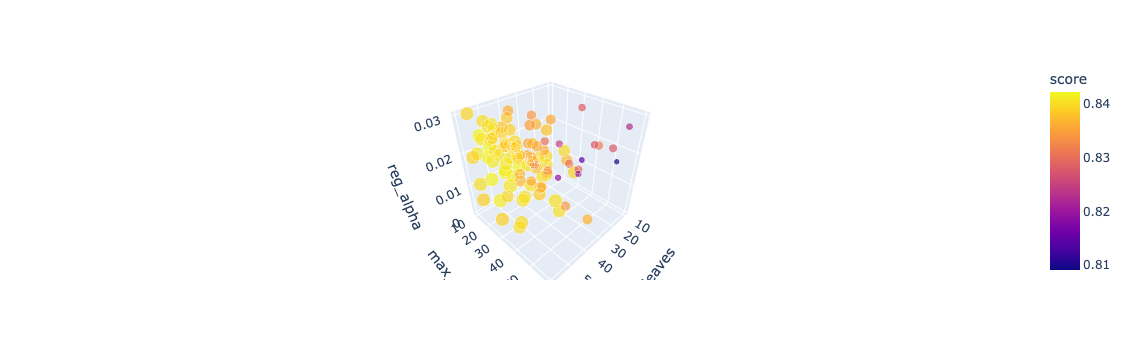

<Figure size 1000x2000 with 0 Axes>

In [131]:
# 描画
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 20))
fig = px.scatter_3d(log_df, x='num_leaves', y='max_depth', z='reg_alpha', size='num_leaves', size_max=11, color='score')
fig.show()